In [ ]:
# %pip install pandas numpy matplotlib
%pip install polars
%pip install yfinance

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import yfinance as yf

In [2]:
# Select an optionid to simulate
selected_option_id = 10010807

### 1. Load Dataset
We will load it with Polars first (suitable for large files) and convert it to a Pandas dataframe when we have filtered the selected optionid.

In [ ]:
# -------------------------
# 1. Load dataset
# -------------------------

# Lazy load with polars (memory efficient for large files)
options_df = pl.scan_parquet("../data/options_dataset.parquet")

# Filter for our selected optionid
options_df = options_df.filter(pl.col("optionid") == selected_option_id).collect()

In [14]:
# Convert polars df to pandas df for easier handling
options_df = options_df.to_pandas()

In [19]:
options_df.head()

,optionid,ticker,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta
0,10010807,SPX,2000-01-03,2000-03-18,C,750000,706.500,708.500,0,1916,NaN,NaN,NaN,NaN,NaN
1,10010807,SPX,2000-01-04,2000-03-18,C,750000,651.875,653.875,0,1916,NaN,NaN,NaN,NaN,NaN
2,10010807,SPX,2000-01-05,2000-03-18,C,750000,654.375,656.375,0,1916,NaN,NaN,NaN,NaN,NaN
3,10010807,SPX,2000-01-06,2000-03-18,C,750000,644.125,646.125,0,1916,NaN,NaN,NaN,NaN,NaN
4,10010807,SPX,2000-01-07,2000-03-18,C,750000,701.500,703.500,0,1916,0.735718,0.98696,0.000072,21.18744,-84.33163


In [16]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   optionid         52 non-null     int64  
 1   ticker           52 non-null     object 
 2   date             52 non-null     object 
 3   exdate           52 non-null     object 
 4   cp_flag          52 non-null     object 
 5   strike_price     52 non-null     int64  
 6   best_bid         52 non-null     float64
 7   best_offer       52 non-null     float64
 8   volume           52 non-null     int64  
 9   open_interest    52 non-null     int64  
 10  impl_volatility  18 non-null     float64
 11  delta            18 non-null     float64
 12  gamma            18 non-null     float64
 13  vega             18 non-null     float64
 14  theta            18 non-null     float64
dtypes: float64(7), int64(4), object(4)
memory usage: 6.2+ KB


In [23]:
options_df["date"].unique()

array(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
       '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
       '2000-01-13', '2000-01-14', '2000-01-18', '2000-01-19',
       '2000-01-20', '2000-01-21', '2000-01-24', '2000-01-25',
       '2000-01-26', '2000-01-27', '2000-01-28', '2000-01-31',
       '2000-02-01', '2000-02-02', '2000-02-03', '2000-02-04',
       '2000-02-07', '2000-02-08', '2000-02-09', '2000-02-10',
       '2000-02-11', '2000-02-14', '2000-02-15', '2000-02-16',
       '2000-02-17', '2000-02-18', '2000-02-22', '2000-02-23',
       '2000-02-24', '2000-02-25', '2000-02-28', '2000-02-29',
       '2000-03-01', '2000-03-02', '2000-03-03', '2000-03-06',
       '2000-03-07', '2000-03-08', '2000-03-09', '2000-03-10',
       '2000-03-13', '2000-03-14', '2000-03-15', '2000-03-16'],
      dtype=object)

### 2. Preprocess Columns

In [47]:
# -------------------------
# 2. Preprocess data
# -------------------------

options_df['date'] = pd.to_datetime(options_df['date'], errors='coerce')

# Add mid-price column
options_df["mid_price"] = (options_df["best_bid"] + options_df["best_offer"]) / 2

### 3. Load underlying SPX prices for the option days
We will download the SPX prices from yfinance.

In [48]:
# -------------------------
# 3. Download and load underlying SPX prices
# -------------------------

ticker = "^SPX"
start_date = options_df["date"].min()
end_date = options_df["date"].max()

spx_df = yf.download(ticker, start=start_date, end=end_date)
spx_df.head()

C:\Users\hengz\AppData\Local\Temp\ipykernel_9488\1789859863.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [49]:
spx_df = spx_df[['Close']].reset_index().rename(columns={'Date': 'date', 'Close': 'spx_close'})
spx_df.columns = [col[0] if isinstance(col, tuple) else col for col in spx_df.columns]
spx_df.head()

,date,spx_close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985
3,2000-01-06,1403.449951
4,2000-01-07,1441.469971


In [50]:
options_df = options_df.merge(spx_df, on='date', how='left')

options_df.head()

,optionid,ticker,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,mid_price,spx_close
0,10010807,SPX,2000-01-03,2000-03-18,C,750000,706.500,708.500,0,1916,NaN,NaN,NaN,NaN,NaN,707.500,1455.219971
1,10010807,SPX,2000-01-04,2000-03-18,C,750000,651.875,653.875,0,1916,NaN,NaN,NaN,NaN,NaN,652.875,1399.420044
2,10010807,SPX,2000-01-05,2000-03-18,C,750000,654.375,656.375,0,1916,NaN,NaN,NaN,NaN,NaN,655.375,1402.109985
3,10010807,SPX,2000-01-06,2000-03-18,C,750000,644.125,646.125,0,1916,NaN,NaN,NaN,NaN,NaN,645.125,1403.449951
4,10010807,SPX,2000-01-07,2000-03-18,C,750000,701.500,703.500,0,1916,0.735718,0.98696,0.000072,21.18744,-84.33163,702.500,1441.469971


### 4. Delta-hedge Simulation

In [51]:
# -------------------------
# 4. Delta-hedge simulation (daily)
# -------------------------
position_option = 1  # long 1 contract
contract_size = 100  # each option contract controls 100 shares
cash = 0
underlying_pos = 0
transaction_cost_pct = 0.001  # 0.1% per trade

results = []

for idx, row in options_df.iterrows():
    date = row['date']
    spx_price = row['spx_close']
    delta = row['delta']
    mid_price = row['mid_price']

    # Target underlying position to delta-hedge
    target_underlying = - position_option * delta * contract_size
    trade = target_underlying - underlying_pos
    trade_notional = abs(trade) * spx_price
    tx_cost = trade_notional * transaction_cost_pct

    # Update cash and underlying position
    cash -= trade * spx_price + tx_cost
    underlying_pos = target_underlying

    # Mark-to-market
    option_value = mid_price * position_option * contract_size
    underlying_value = underlying_pos * spx_price
    total_value = cash + option_value + underlying_value

    results.append({
        'date': date,
        'option_value': option_value,
        'underlying_value': underlying_value,
        'cash': cash,
        'total_value': total_value,
        'tx_cost': tx_cost
    })

results_df = pd.DataFrame(results)


### 5. Plot Results

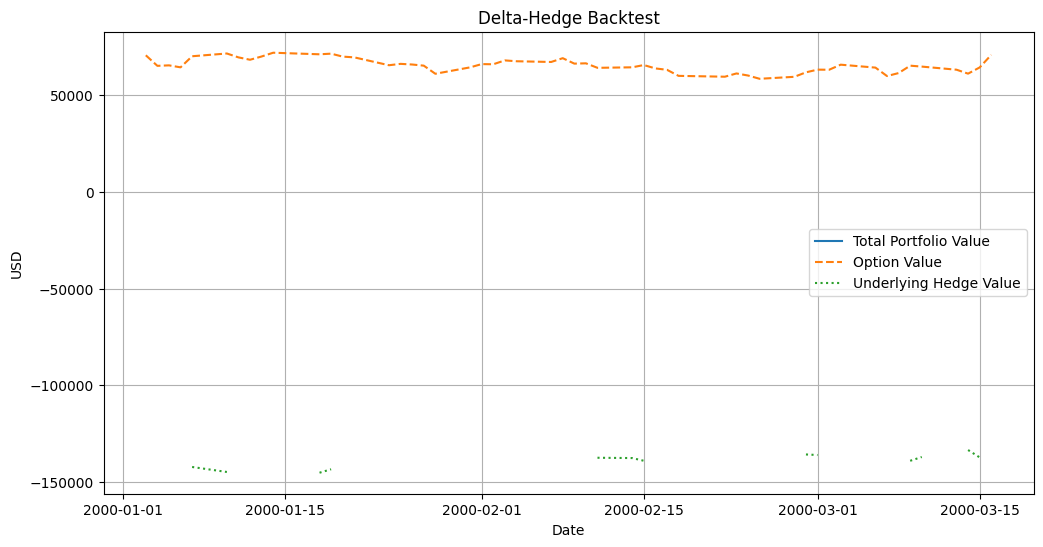

In [52]:
# -------------------------
# 5. Plot results
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(results_df['date'], results_df['total_value'], label='Total Portfolio Value')
plt.plot(results_df['date'], results_df['option_value'], label='Option Value', linestyle='--')
plt.plot(results_df['date'], results_df['underlying_value'], label='Underlying Hedge Value', linestyle=':')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Delta-Hedge Backtest')
plt.legend()
plt.grid(True)
plt.show()